In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import copy
import os

import sys
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from helper import df_to_latex, fig_path, set_figsize, tab_path

# Import code from src
sys.path.insert(0, '../src/')
import vmc 

# Set plot style
sns.set(context="paper", style='darkgrid', rc={"axes.facecolor": "0.96"})

# Set fontsizes in figures
fontsize = 10
tex_fonts = {
    "text.usetex": True,
    "font.family": "serif",
    "font.sans-serif": ["Computer Modern"],
    "axes.labelsize": fontsize,
    "font.size": fontsize,
    "legend.fontsize": fontsize,
    "xtick.labelsize": fontsize-1,
    "ytick.labelsize": fontsize-1,
    'legend.handlelength': 2
}

plt.rcParams.update(tex_fonts)

# Set figure size
width = 410 #360
figsize = set_figsize(width, fraction=1)

In [2]:
def exact_energy(N, dim, omega):
    return (omega * dim * N) / 2

def safe_initial_positions_no_interactions(wavefunction, alpha, N, dim, seed=None):
    rng = np.random.default_rng(seed=seed)
    positions = rng.random(size=(N, dim))

    # safe initialization
    wf2 = wavefunction.pdf(positions, alpha)
    while np.sum(wf2) <= 1e-14:
        positions *= 0.5
        wf2 = wavefunction.pdf(positions, alpha)

    return positions

def safe_initial_positions_w_interactions(wavefunction, alpha, N, dim, seed=None): 
    rng = np.random.default_rng(seed=seed)
    positions = rng.random(size=(N, dim))
    
    # safe initialization
    wf2 = wavefunction.pdf(positions, alpha)
    while np.sum(wf2) <= 1e-14: 
        positions *= 2.0
        wf2 = wavefunction.pdf(positions, alpha)
        
    return positions

def interact_initial_positions(wf, alpha, N, dim, a=0.00433):

    rng = np.random.default_rng()

    def corr_factor(r1, r2):
        rij = np.linalg.norm(r1 - r2)
        if rij <= a:
            return 0.
        else:
            return 1 - (a / rij)

    scale = 2.
    r = np.random.randn(N, dim) * scale
    #r = rng.random(size=(N, dim))

    rerun = True
    while rerun:
        rerun = False
        for i in range(N):
            for j in range(i + 1, N):
                corr = corr_factor(r[i, :], r[j, :])
                if corr == 0.:
                    print("corr=0 encountered")
                    rerun = True
                    r[i, :] = np.random.randn() * scale
                    r[j, :] = np.random.randn() * scale
        scale *= 1.5

    return r, scale

## Grid search $\alpha$ with interactions

In [3]:
N = 10
dim = 3
omega = 1.

# Exact energy without interactions
NI_exact_energy_10 = exact_energy(N, dim, omega)
# Instantiate wave function
wf = vmc.ASHOIB(N, dim, omega)

# Instantiate sampler
sampler = vmc.samplers.Metropolis(wf)

# Config
nsamples = 20000
alpha_step = 0.05
alphas = np.arange(0.1, 1 + alpha_step, alpha_step)

results = []

start = time.time()
for i, alpha in enumerate(alphas):
    initial_positions, scale = interact_initial_positions(wf,
                                                          alpha,
                                                          N,
                                                          dim)
    result = sampler.sample(nsamples,
                            initial_positions,
                            alpha,
                            nchains=1,
                            scale=1.0,
                            seed=None,
                            warm=True,
                            warmup_iter=500,
                            tune=True,
                            tune_iter=10000,
                            tune_interval=250,
                            tol_tune=1e-7,
                            optimize=False
                           )
    results.append(result)

end = time.time()
print("Sampler elapsed time:", end - start)

Warm done
Final acceptance rate 0.416 and scale 0.5
Tune done
Sampling energy
Warm done
Final acceptance rate 0.264 and scale 0.6561000000000001
Tune done
Sampling energy
Warm done
Final acceptance rate 0.304 and scale 0.5
Tune done
Sampling energy
Warm done
Final acceptance rate 0.356 and scale 0.45
Tune done
Sampling energy
Warm done
Final acceptance rate 0.392 and scale 0.26620000000000005
Tune done
Sampling energy
Warm done
Final acceptance rate 0.24 and scale 0.405
Tune done
Sampling energy
Warm done
Final acceptance rate 0.2 and scale 0.405
Tune done
Sampling energy
Warm done
Final acceptance rate 0.2 and scale 0.36450000000000005
Tune done
Sampling energy
Warm done
Final acceptance rate 0.24 and scale 0.32805000000000006
Tune done
Sampling energy
Warm done
Final acceptance rate 0.228 and scale 0.32805000000000006
Tune done
Sampling energy
Warm done
Final acceptance rate 0.232 and scale 0.32805000000000006
Tune done
Sampling energy
Warm done
Final acceptance rate 0.376 and scale 

In [4]:
df_N10 = pd.concat(results, ignore_index=True)
df_N10

,nparticles,dim,alpha,energy,standard_error,accept_rate
0,10,3,0.10,39.310586,1.745910,0.42475
1,10,3,0.15,26.615716,0.541398,0.18485
2,10,3,0.20,21.416652,0.331296,0.24625
3,10,3,0.25,18.325878,0.184305,0.24865
4,10,3,0.30,17.012770,0.343973,0.48700
5,10,3,0.35,15.959294,0.096073,0.22395
6,10,3,0.40,15.437320,0.072110,0.17130
7,10,3,0.45,15.260281,0.032894,0.20710
8,10,3,0.50,15.176191,0.001447,0.22535
9,10,3,0.55,15.293782,0.034674,0.20235


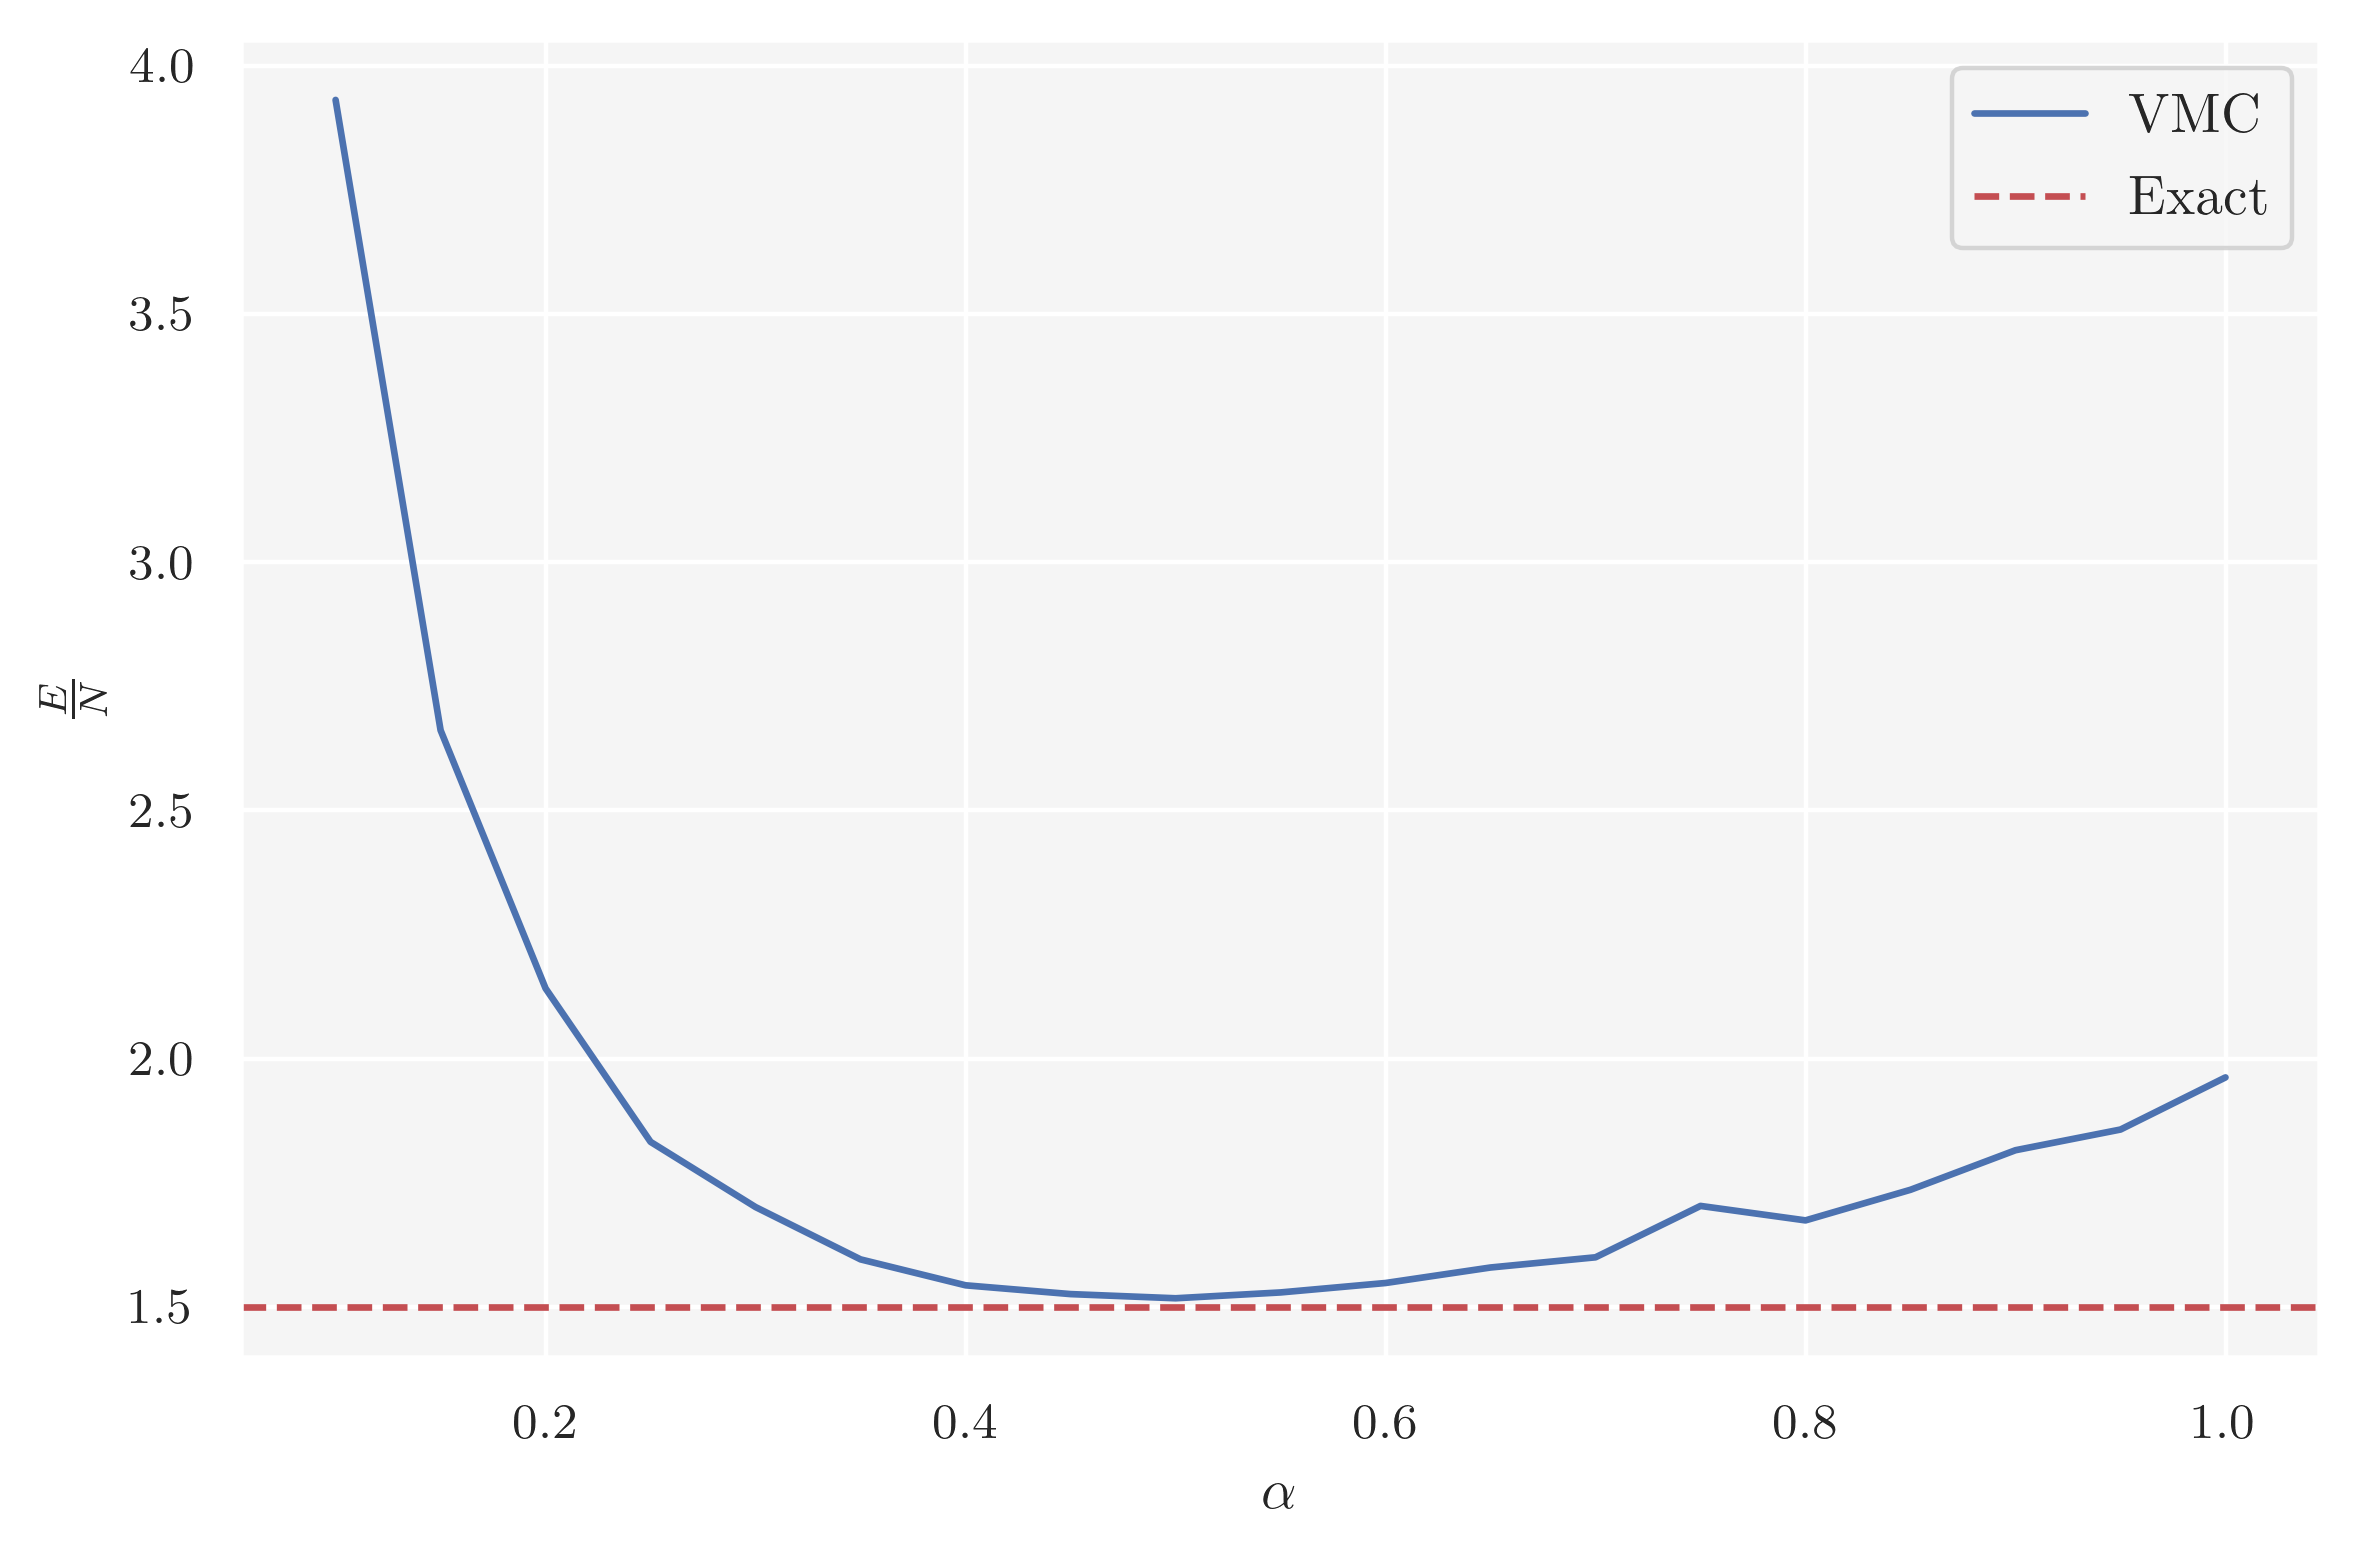

In [5]:
mod_df_10 = df_N10
mod_df_10["energy"] = mod_df_10["energy"]/10.0
fig, ax = plt.subplots(figsize=(6, 4), tight_layout=True, dpi=200)
sns.lineplot(data=mod_df_10, x="alpha", y="energy", ax=ax, label="VMC")
ax.axhline(NI_exact_energy_10/10.0, ls='--', color='r', label='Exact')
ax.set(xlabel=r'$\alpha$', ylabel=r'$\frac{E}{N}$')
ax.legend()
plt.show()

fig.savefig(fig_path("grid_search_analytical_w_interactions_N_10.pdf"), bbox_inches='tight')

In [6]:
N = 50
dim = 3
omega = 1.

# Exact energy without interactions
NI_exact_energy_50 = exact_energy(N, dim, omega)
# Instantiate wave function
wf = vmc.ASHOIB(N, dim, omega)

# Instantiate sampler
sampler = vmc.samplers.Metropolis(wf)

# Config
nsamples = 20000
alpha_step = 0.05
alphas = np.arange(0.1, 1 + alpha_step, alpha_step)

results_N50 = []

start = time.time()
for i, alpha in enumerate(alphas):
    initial_positions, scale = interact_initial_positions(wf,
                                                          alpha,
                                                          N,
                                                          dim)
    result = sampler.sample(nsamples,
                            initial_positions,
                            alpha,
                            nchains=1,
                            scale=1.0,
                            seed=None,
                            warm=True,
                            warmup_iter=500,
                            tune=True,
                            tune_iter=10000,
                            tune_interval=500,
                            tol_tune=1e-5,
                            optimize=False
                           )
    results_N50.append(result)

end = time.time()
print("Sampler elapsed time:", end - start)

Warm done
Final acceptance rate 0.296 and scale 0.32805000000000006
Tune done
Sampling energy
Warm done
Final acceptance rate 0.248 and scale 0.22000000000000003
Tune done
Sampling energy
Warm done
Final acceptance rate 0.276 and scale 0.13310000000000002
Tune done
Sampling energy
Warm done
Final acceptance rate 0.266 and scale 0.2025
Tune done
Sampling energy
Warm done
Final acceptance rate 0.364 and scale 0.11000000000000001
Tune done
Sampling energy
Warm done
Final acceptance rate 0.43 and scale 0.12100000000000002
Tune done
Sampling energy
Warm done
Final acceptance rate 0.326 and scale 0.11000000000000001
Tune done
Sampling energy
Warm done
Final acceptance rate 0.45 and scale 0.11137500000000002
Tune done
Sampling energy
Warm done
Final acceptance rate 0.306 and scale 0.11957422500000003
Tune done
Sampling energy
Warm done
Final acceptance rate 0.216 and scale 0.14762250000000005
Tune done
Sampling energy
Warm done
Final acceptance rate 0.462 and scale 0.1
Tune done
Sampling ener

In [7]:
df_N50 = pd.concat(results_N50, ignore_index=True)
df_N50

,nparticles,dim,alpha,energy,standard_error,accept_rate
0,50,3,0.10,203.339625,6.359869,0.22440
1,50,3,0.15,131.054905,3.253901,0.35665
2,50,3,0.20,124.375127,7.095243,0.49295
3,50,3,0.25,96.092960,1.076107,0.24935
4,50,3,0.30,91.595690,1.994184,0.53710
5,50,3,0.35,81.369995,1.079962,0.47515
6,50,3,0.40,83.875421,1.275411,0.43695
7,50,3,0.45,80.048524,0.444083,0.42930
8,50,3,0.50,79.761862,0.019853,0.35125
9,50,3,0.55,79.073781,0.503523,0.20490


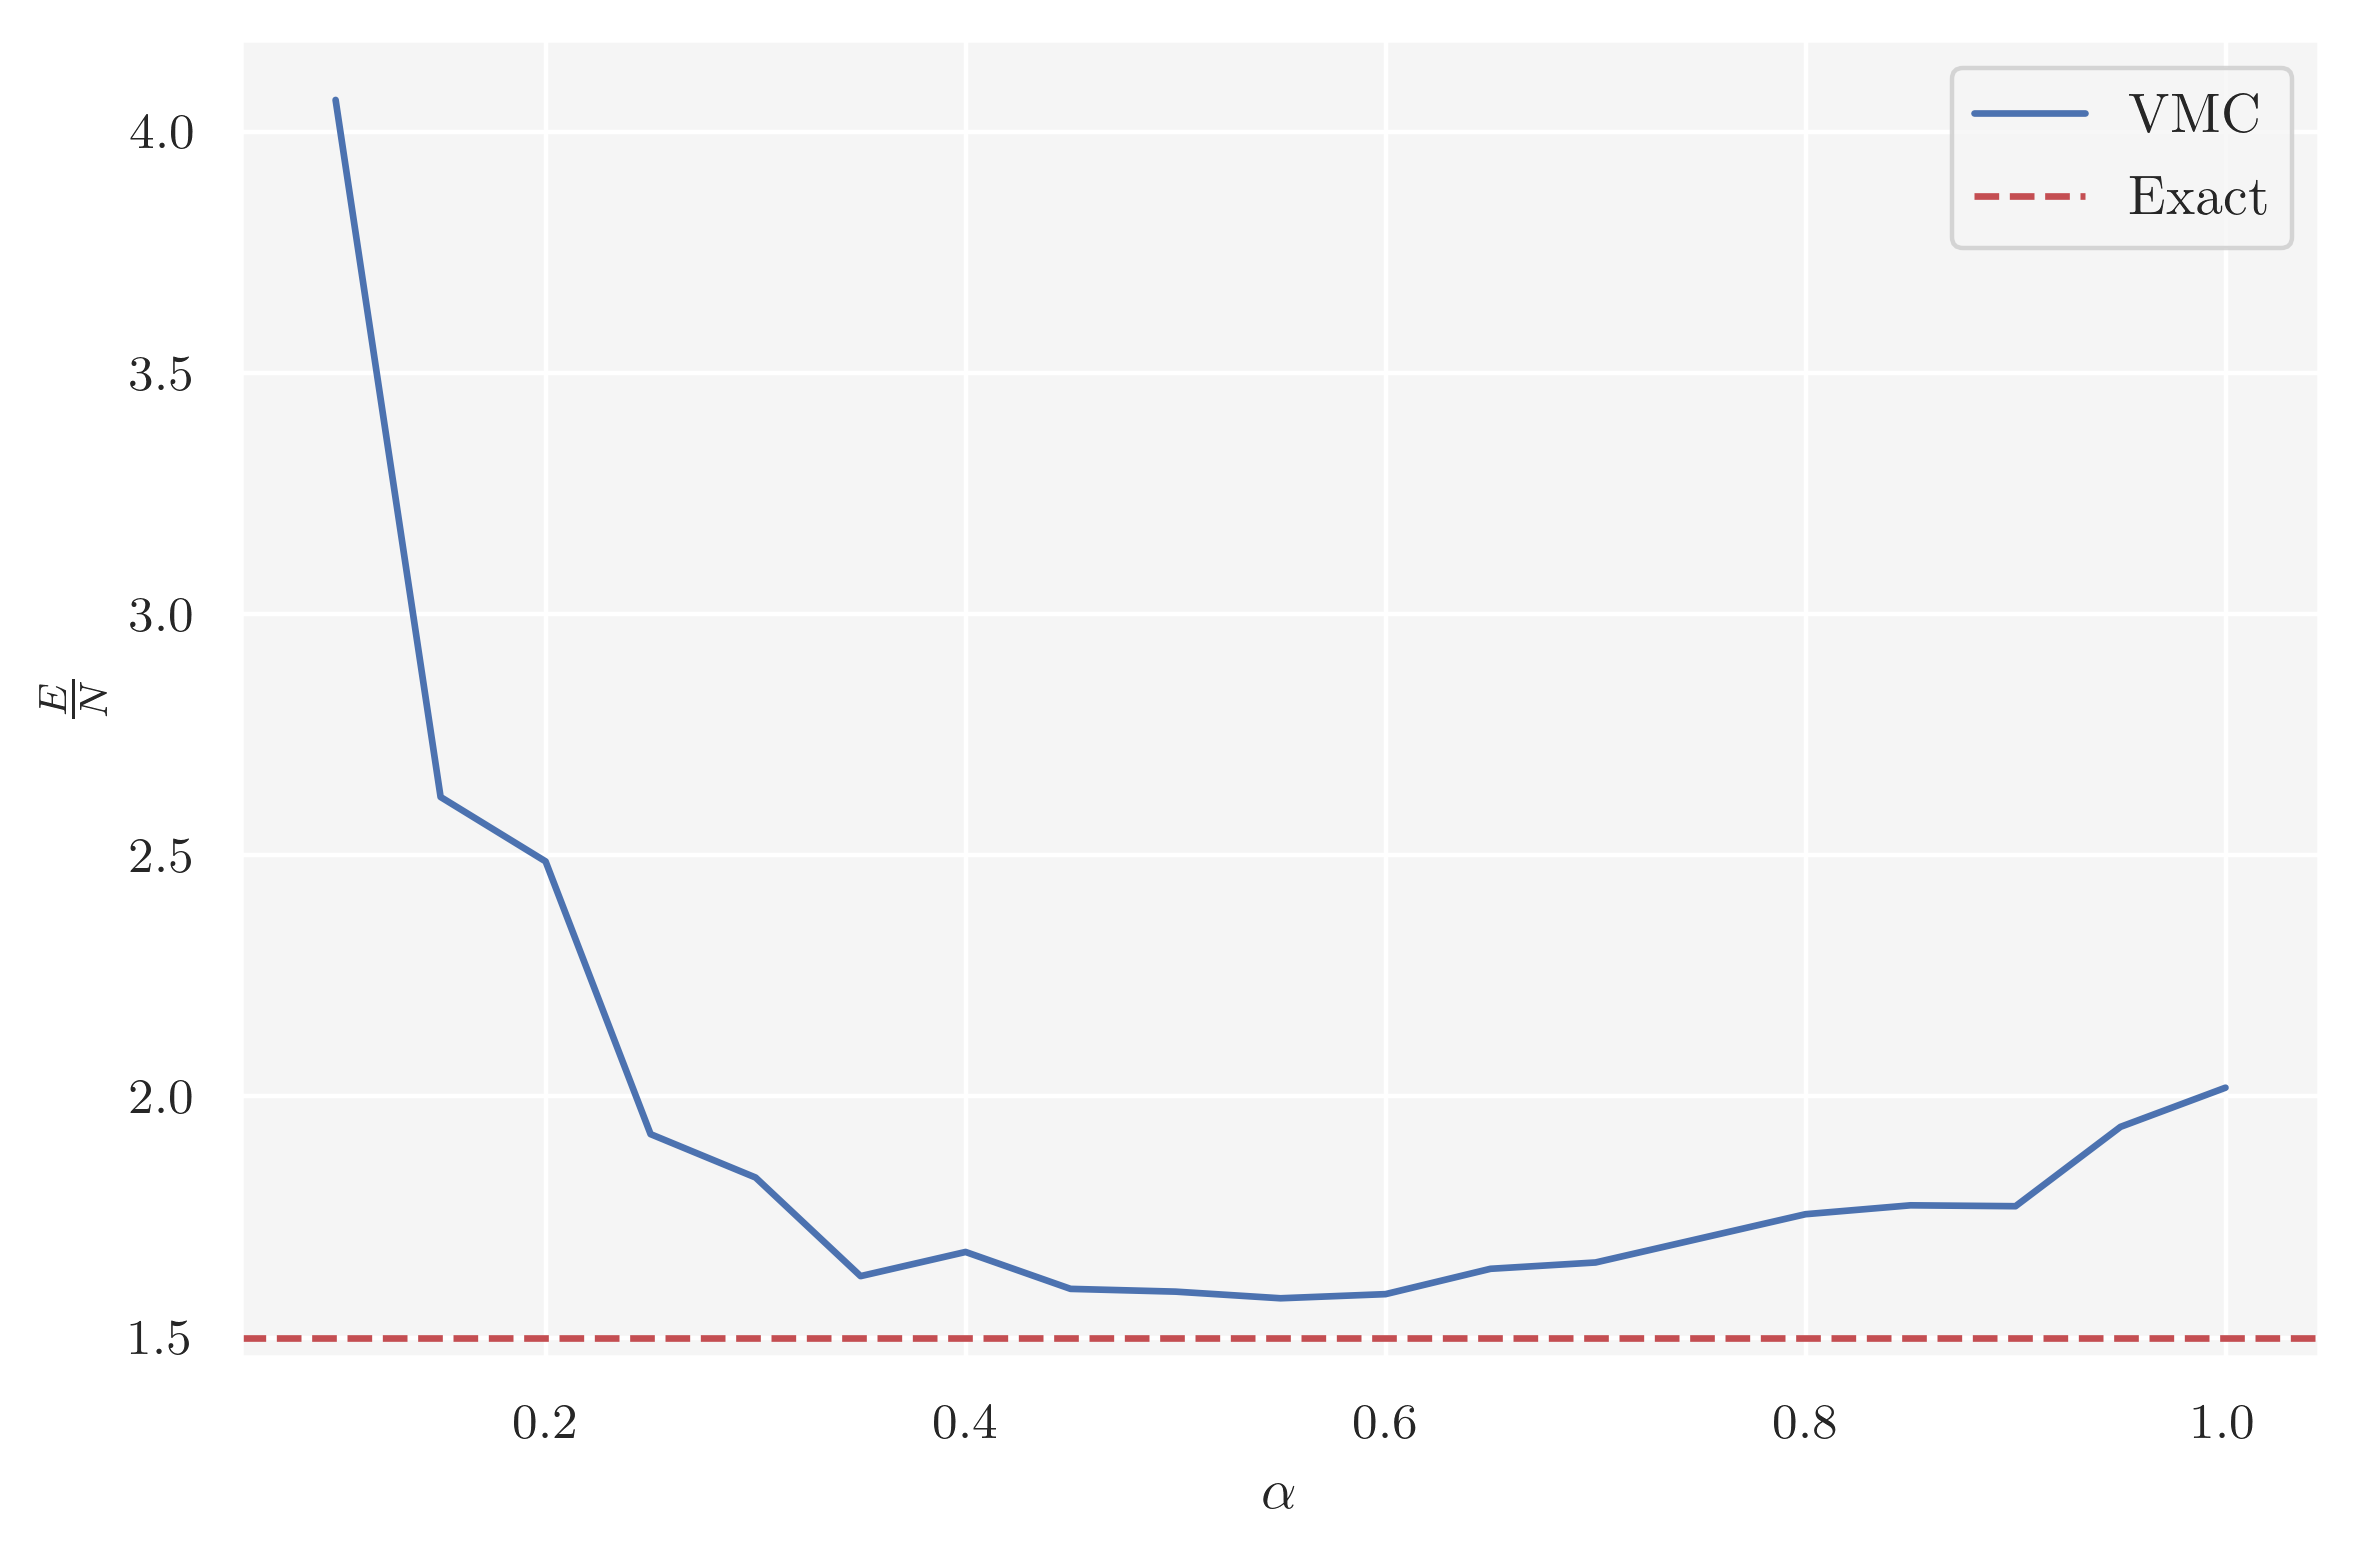

In [8]:
mod_df_50 = df_N50
mod_df_50["energy"] = mod_df_50["energy"]/50.0
fig, ax = plt.subplots(figsize=(6, 4), tight_layout=True, dpi=200)
sns.lineplot(data=mod_df_50, x="alpha", y="energy", ax=ax, label="VMC")
ax.axhline(NI_exact_energy_50/50.0, ls='--', color='r', label='Exact')
ax.set(xlabel=r'$\alpha$', ylabel=r'$\frac{E}{N}$')
ax.legend()
plt.show()

fig.savefig(fig_path("grid_search_analytical_w_interactions_N_50.pdf"), bbox_inches='tight')

In [9]:
N = 100
dim = 3
omega = 1.

# Exact energy without interactions
NI_exact_energy_100 = exact_energy(N, dim, omega)
# Instantiate wave function
wf = vmc.ASHOIB(N, dim, omega)

# Instantiate sampler
sampler = vmc.samplers.Metropolis(wf)

# Config
nsamples = 20000
alpha_step = 0.05
alphas = np.arange(0.1, 1 + alpha_step, alpha_step)

results_N100 = []

start = time.time()
for i, alpha in enumerate(alphas):
    initial_positions, scale = interact_initial_positions(wf,
                                                          alpha,
                                                          N,
                                                          dim)
    result = sampler.sample(nsamples,
                            initial_positions,
                            alpha,
                            nchains=1,
                            scale=1.0,
                            seed=None,
                            warm=True,
                            warmup_iter=500,
                            tune=True,
                            tune_iter=5000,
                            tune_interval=250,
                            tol_tune=1e-5,
                            optimize=False
                           )
    results_N100.append(result)

end = time.time()
print("Sampler elapsed time:", end - start)

Warm done
Final acceptance rate 0.424 and scale 0.13310000000000002
Tune done
Sampling energy
Warm done
Final acceptance rate 0.5 and scale 0.1
Tune done
Sampling energy
Warm done
Final acceptance rate 0.476 and scale 0.1
Tune done
Sampling energy
Warm done
Final acceptance rate 0.412 and scale 0.1
Tune done
Sampling energy
Warm done
Final acceptance rate 0.36 and scale 0.1
Tune done
Sampling energy
Warm done
Final acceptance rate 0.428 and scale 0.1
Tune done
Sampling energy
Warm done
Final acceptance rate 0.344 and scale 0.1
Tune done
Sampling energy
Warm done
Final acceptance rate 0.416 and scale 0.1
Tune done
Sampling energy
Warm done
Final acceptance rate 0.428 and scale 0.1
Tune done
Sampling energy
Warm done
Final acceptance rate 0.44 and scale 0.1
Tune done
Sampling energy
Warm done
Final acceptance rate 0.36 and scale 0.1
Tune done
Sampling energy
Warm done
Final acceptance rate 0.34 and scale 0.1
Tune done
Sampling energy
Warm done
Final acceptance rate 0.26 and scale 0.1
Tun

In [10]:
df_N100 = pd.concat(results_N100, ignore_index=True)
df_N100

,nparticles,dim,alpha,energy,standard_error,accept_rate
0,100,3,0.10,416.246199,20.475992,0.53655
1,100,3,0.15,257.206343,8.293524,0.58595
2,100,3,0.20,238.929886,11.125393,0.48450
3,100,3,0.25,208.216182,8.558452,0.47220
4,100,3,0.30,198.134128,8.791580,0.41365
5,100,3,0.35,180.772286,3.950602,0.36685
6,100,3,0.40,170.150095,2.073328,0.35365
7,100,3,0.45,167.396317,1.082448,0.34345
8,100,3,0.50,166.829832,0.241503,0.28900
9,100,3,0.55,166.154603,2.040219,0.25115


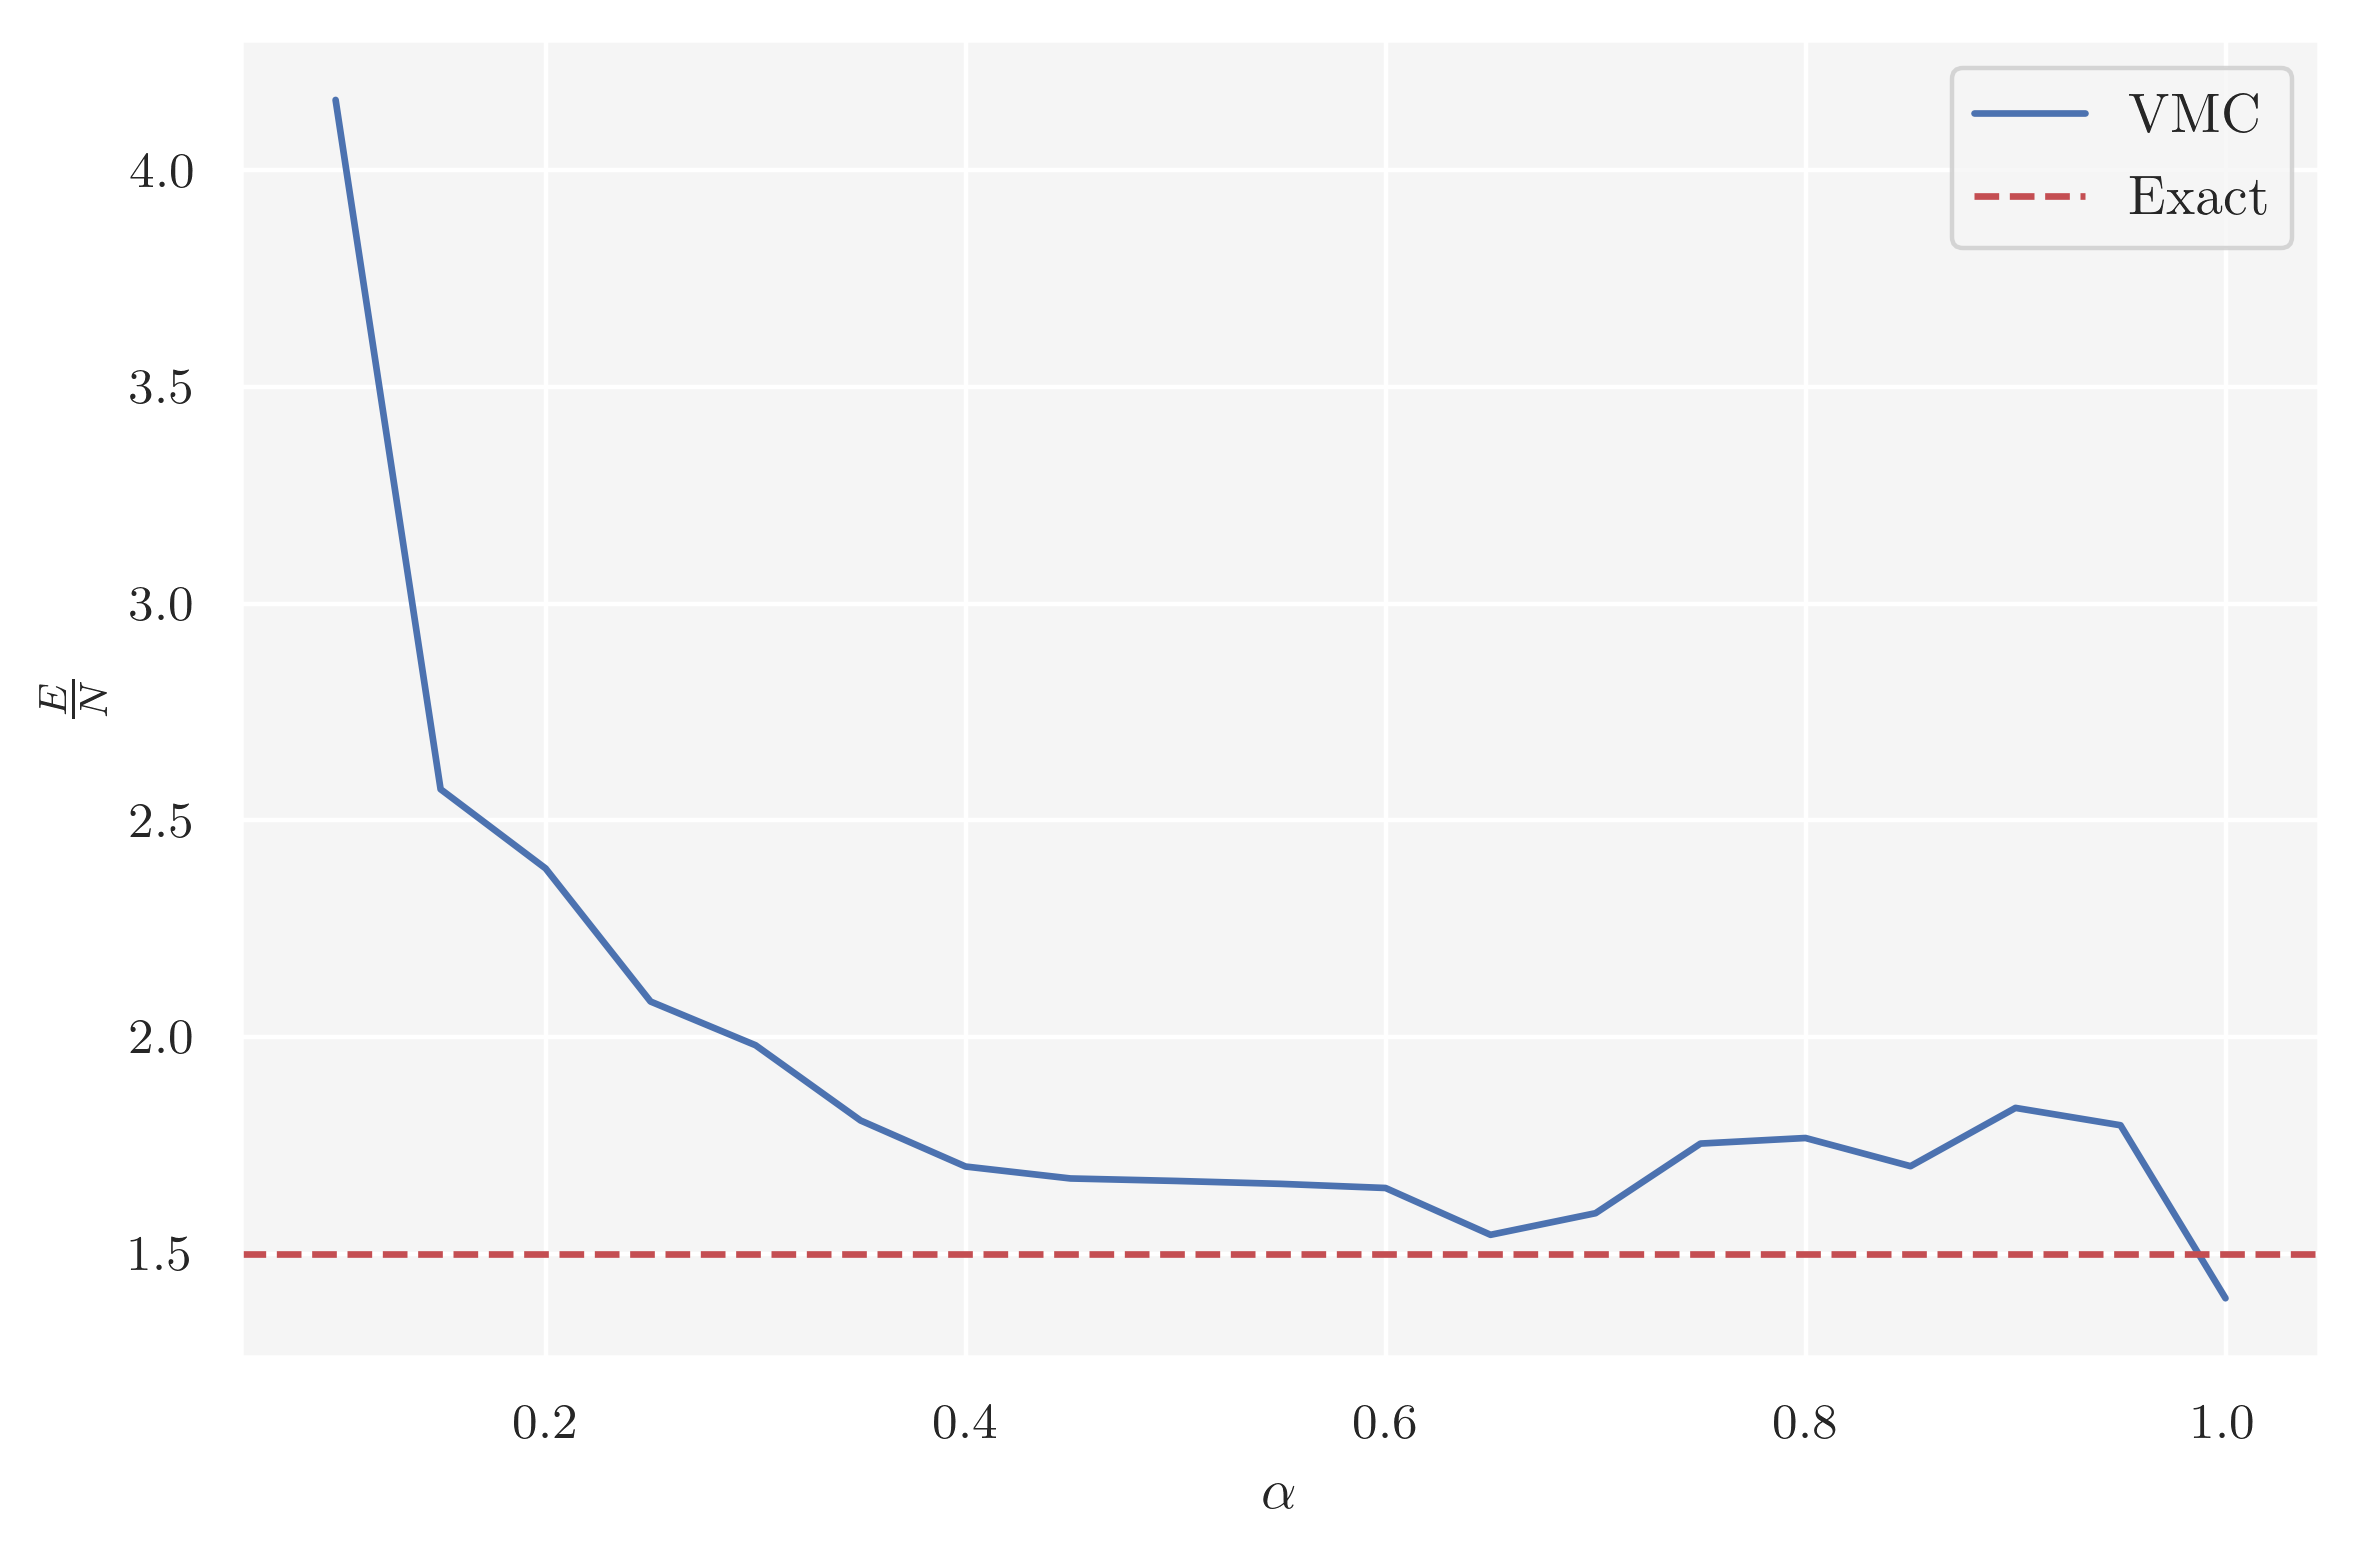

In [11]:
mod_df_100 = df_N100
mod_df_100["energy"] = mod_df_100["energy"]/100.0
fig, ax = plt.subplots(figsize=(6, 4), tight_layout=True, dpi=200)
sns.lineplot(data=mod_df_100, x="alpha", y="energy", ax=ax, label="VMC")
ax.axhline(NI_exact_energy_100/100.0, ls='--', color='r', label='Exact')
ax.set(xlabel=r'$\alpha$', ylabel=r'$\frac{E}{N}$')
ax.legend()
plt.show()

fig.savefig(fig_path("grid_search_analytical_w_interactions_N_100.pdf"), bbox_inches='tight')

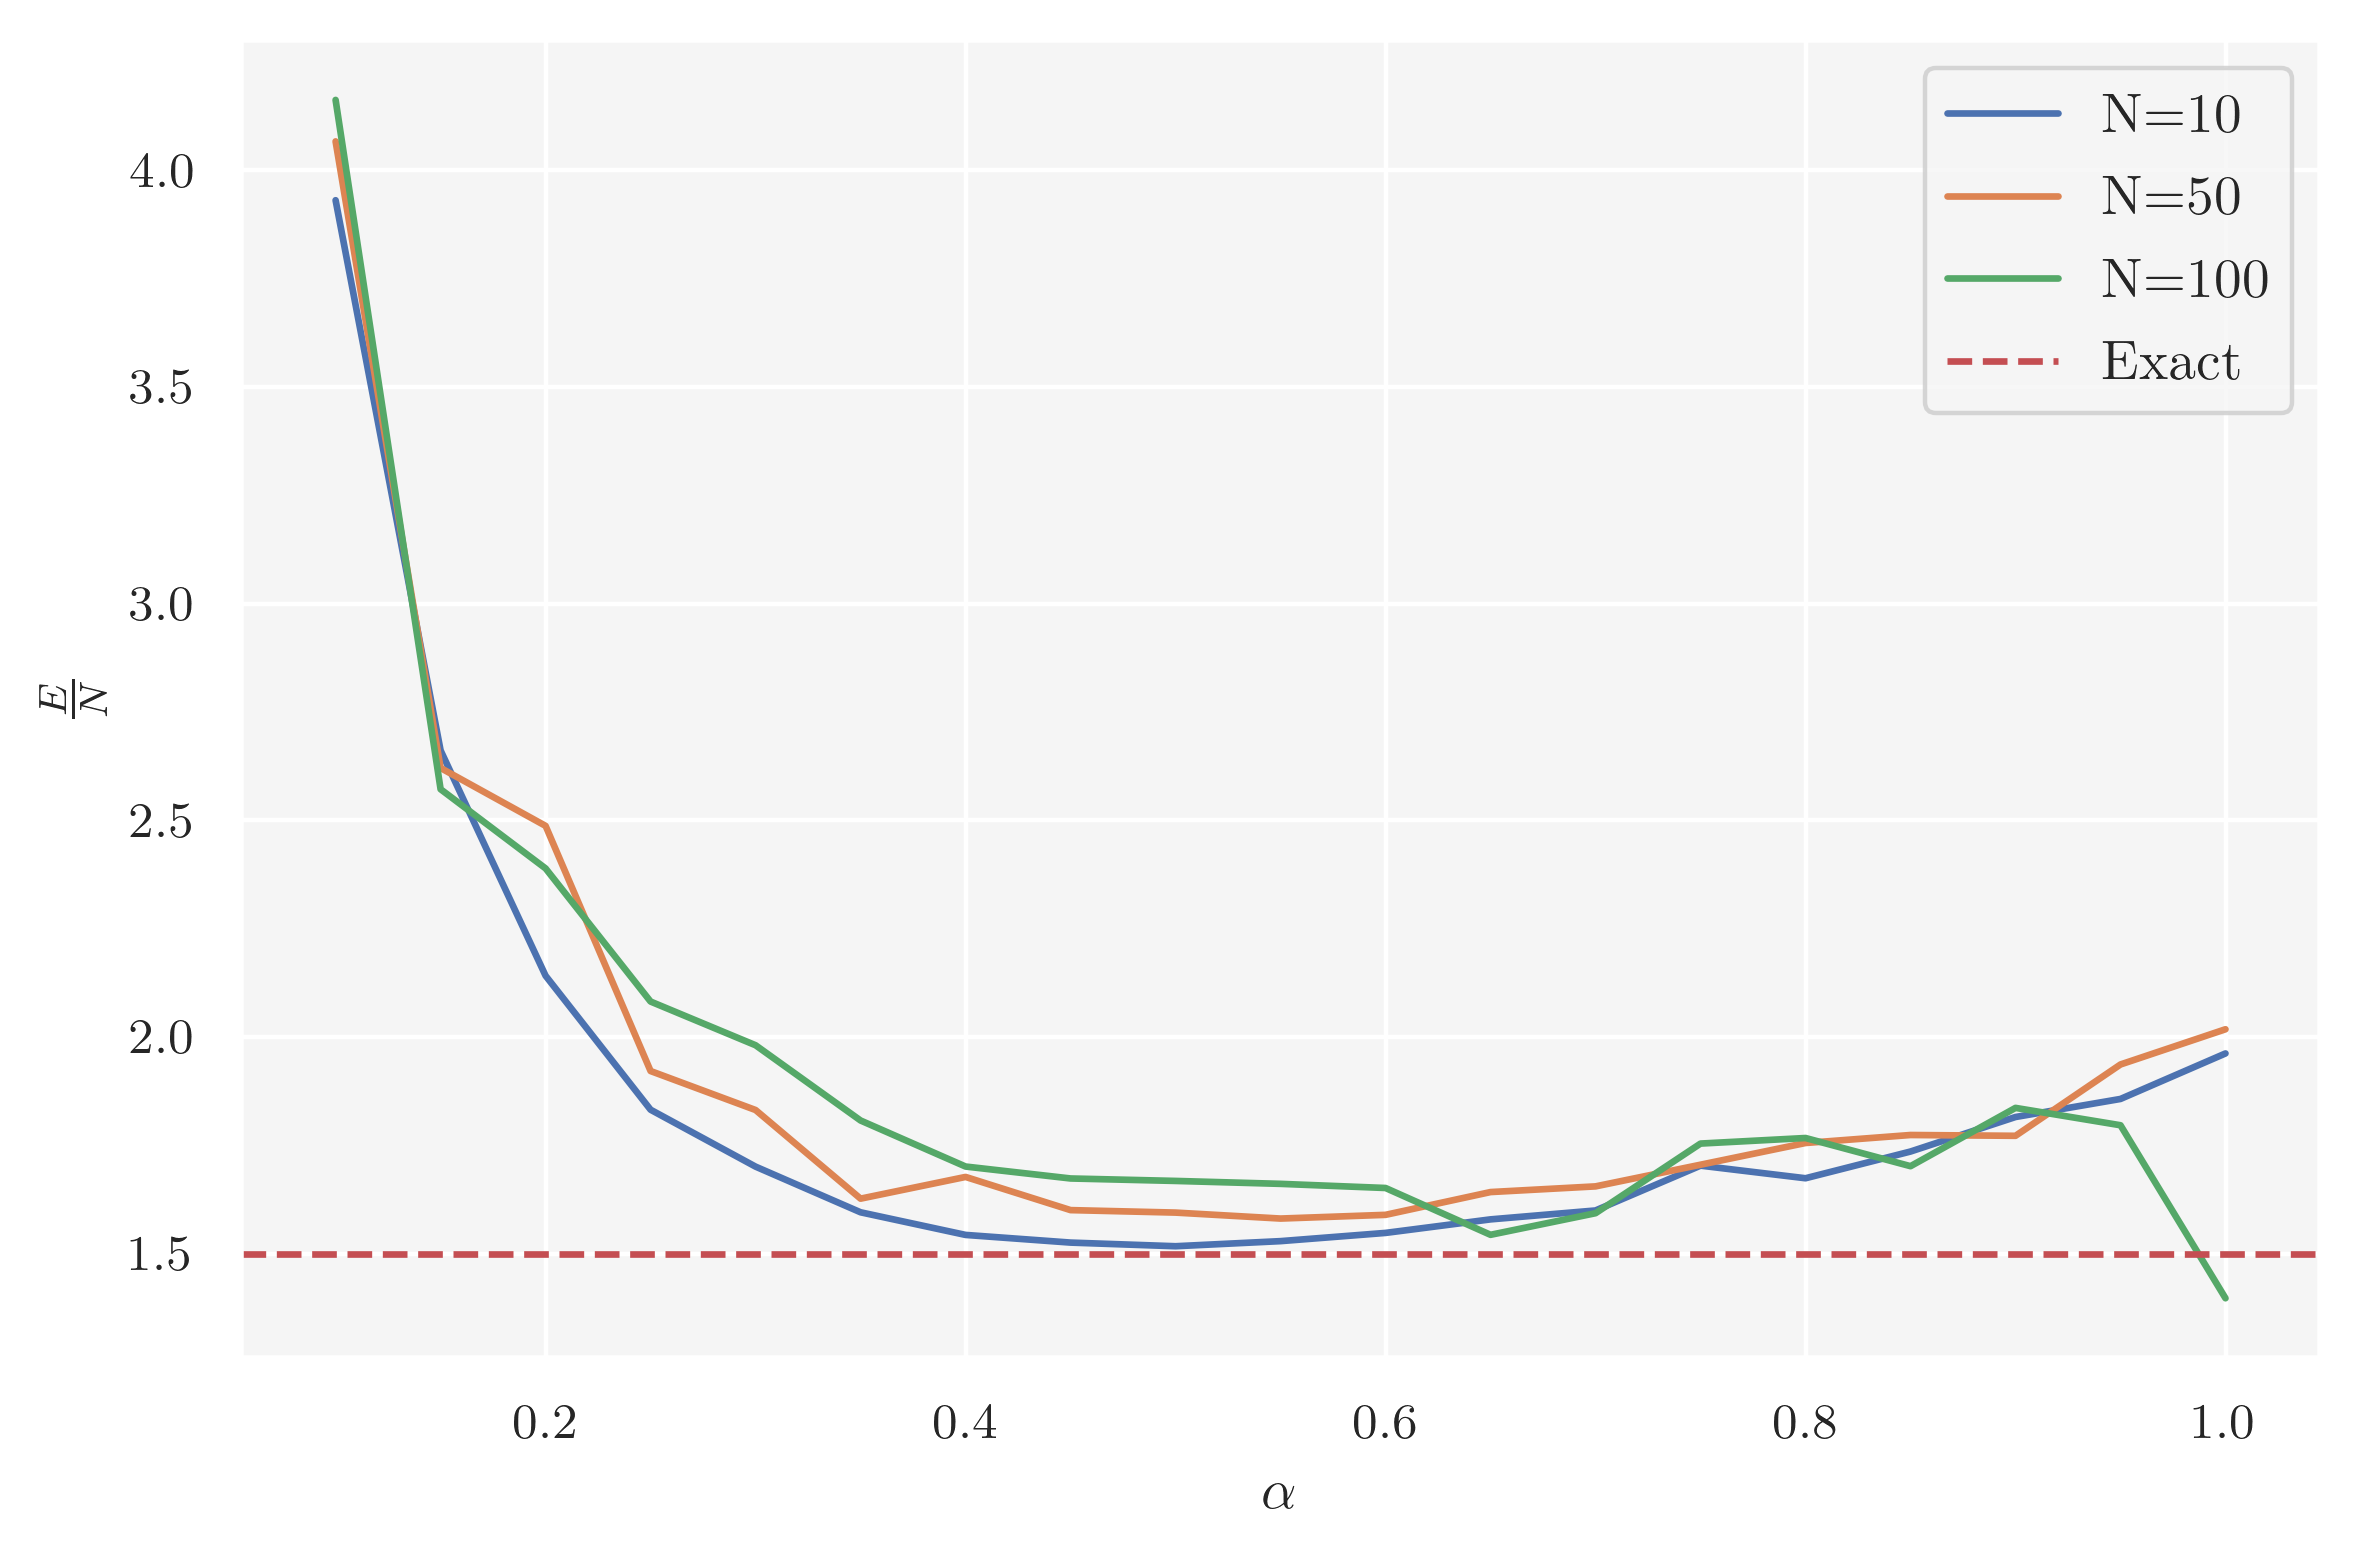

In [12]:
fig, ax = plt.subplots(figsize=(6,4), tight_layout=True, dpi=200)
sns.lineplot(data=mod_df_10, x="alpha", y="energy", ax=ax, label="N=10")
sns.lineplot(data=mod_df_50, x="alpha", y="energy", ax=ax, label="N=50")
sns.lineplot(data=mod_df_100, x="alpha", y="energy", ax=ax, label="N=100")
ax.axhline(NI_exact_energy_100/100.0, ls='--', color='r', label='Exact')
ax.set(xlabel=r'$\alpha$', ylabel=r'$\frac{E}{N}$')
ax.legend()
plt.show()

fig.savefig(fig_path("grid_search_analytical_w_interactions_all_N.pdf"), bbox_inches='tight')